# Box plots of error rates over 100 samples

In [10]:
import numpy as np
import pandas as pd
import csv
import os
import pprint
from timeit import timeit
from functools import partial
import seaborn as sbn
np.random.seed(12345)
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from random import random


In [11]:
#--- constants(do not change) ---
kFold = 10
iters = 100
cpus = 4

In [12]:
#--- data preparation utilities ---

pp = pprint.PrettyPrinter(indent=4)

# popularity detector
def popular(s):
    return 1 if s>1400 else 0

#drop url and time, standardize everything else
def prepare(data):
    data_no_url_time = data.drop(['url',' timedelta','Unnamed: 0'],axis = 1)
    scaled_data = data_no_url_time.copy()
    for column in data_no_url_time.columns:
        if column!=' shares':
            scaled_data[column] = preprocessing.scale(data_no_url_time[column])
    scaled_data[' popularity'] = scaled_data[' shares'].apply(popular)
    std_data = scaled_data.drop([' shares'],axis=1)
    return std_data

#takes dataframes containing both predictor and the output and separates them
def make_train_test(train, test, lastColumnTrain, columnOutput):
    x_train = train.loc[:,:lastColumnTrain]
    y_train = train.loc[:,columnOutput]
    x_test = test.loc[:,:lastColumnTrain]
    y_test = test.loc[:,columnOutput]
    return x_train, y_train, x_test, y_test


In [13]:
# I/O utilities
def summary(cl, y_pred, y_test):
    print ("coefficients = ", cl.coef_)
    print ("intercepts = ", cl.intercept_)
    print ("iterations = ", cl.n_iter_)

def plot_misclassification(m):
    labels, data = [*zip(*m.items())]  # 'transpose' items to parallel key, value lists
    plt.boxplot(data)
    plt.xticks(range(1, len(labels) + 1), labels)
    plt.show()


    

In [14]:
#--- classifiers ---
alphas = np.logspace(-5,5,100)

def logistic_plain_cv(x_train, y_train, x_test):
    clf = LogisticRegressionCV(cv=kFold, 
                               max_iter=100000,
                               n_jobs=cpus)
    clf.fit(x_train, y_train)
    y_pred_test = [1 if p > 0.5 else 0 for p in clf.predict(x_test)]
    y_pred_train = [1 if p > 0.5 else 0 for p in clf.predict(x_train)]
    return clf, y_pred_train, y_pred_test

def random_forest(x_train, y_train, x_test):
    clf = RandomForestClassifier(n_estimators=100,
                                n_jobs=cpus)
    clf.fit(x_train, y_train)
    y_pred_test = [1 if p > 0.5 else 0 for p in clf.predict(x_test)]
    y_pred_train = [1 if p > 0.5 else 0 for p in clf.predict(x_train)]
    return clf, y_pred_train, y_pred_test

def lasso_cv(x_train, y_train, x_test):
    clf = LassoCV(alphas=alphas,
                  cv=kFold,
                  max_iter=100000)
    clf.fit(x_train, y_train)
    y_pred_test = [1 if p > 0.5 else 0 for p in clf.predict(x_test)]
    y_pred_train = [1 if p > 0.5 else 0 for p in clf.predict(x_train)]
    return clf, y_pred_train, y_pred_test

def elastic_net_cv(x_train, y_train, x_test):
    clf = ElasticNetCV(alphas=alphas,
                       cv=kFold,
                       max_iter=100000,
                       n_jobs=cpus)
    clf.fit(x_train, y_train)
    y_pred_test = [1 if p > 0.5 else 0 for p in clf.predict(x_test)]
    y_pred_train = [1 if p > 0.5 else 0 for p in clf.predict(x_train)]
    return clf, y_pred_train, y_pred_test

def ridge_cv(x_train, y_train, x_test):
    clf = RidgeCV(alphas=alphas,
                  cv=kFold)
    clf.fit(x_train, y_train)
    y_pred_test = [1 if p > 0.5 else 0 for p in clf.predict(x_test)]
    y_pred_train = [1 if p > 0.5 else 0 for p in clf.predict(x_train)]
    return clf, y_pred_train, y_pred_test

def svc(x_train, y_train, x_test):
    parameter_space = [
        {'kernel': ['rbf'],
         'gamma': np.logspace(-1,2,10),
         'C': np.logspace(-1,2,10)}
    ]
    clf = GridSearchCV(SVC(),
                       parameter_space,
                       cv=kFold,
                       iid=True,
                       scoring='accuracy',
                       n_jobs=cpus)
    clf.fit(x_train, y_train)
    y_pred_test = [1 if p > 0.5 else 0 for p in clf.predict(x_test)]
    y_pred_train = [1 if p > 0.5 else 0 for p in clf.predict(x_train)]
    return clf, y_pred_train, y_pred_test

In [15]:
#--- test models against fake data ---

def make_data_up(noise):
    data = {'predictor': [], 'output': []}
    for i in range(1000):
        r = random()
        v = True if r > 0.5 else False
        if random() < noise :
            v = not v
        data['predictor'].append(r)
        data['output'].append(1 if v else 0)
    made_up_data = pd.DataFrame(data)
    made_up_data['predictor'] = preprocessing.scale(made_up_data['predictor'])
    return made_up_data

def test_with_fake_data(data, classifier):
    p = data.loc[:,:'predictor'].columns.size
    n = len(data.index)
    learning_set_sizes = {'10p': 10*p, '50p': 50*p}
    misclassification_rates = {'10p': [], '50p': []}
    for iteration in range(iters):
        for size_case in learning_set_sizes:
            #print('-'*80)
            #print ("iteration: ", iteration+1, " of ", iters)
            #print("case: ", size_case)
            size = learning_set_sizes[size_case]
            #print("learning set size =", size)
            train_set,test_set = train_test_split(data, test_size= 1.0*size/n)
            x_train, y_train, x_test, y_test = make_train_test(train_set, test_set, 'predictor', 'output')
            clf, y_pred = classifier(x_train, y_train, x_test)
            #summary(clf, y_pred, y_test)
            misclassification_rates[size_case].append(1.0 - accuracy_score(y_test, y_pred))
            #print('-'*80)
    #print("Misclassification rates:", misclassification_rates)
    plot_misclassification(misclassification_rates)
    
fake_data = make_data_up(0.1)

# print("---RANDOM FOREST---")
# test_with_fake_data(fake_data, random_forest)
# print("---RADIAL SVM---")
# test_with_fake_data(fake_data, svc)
# print("---LOGISTIC CV---")
# test_with_fake_data(fake_data, logistic_plain_cv)
# print("---LOGISTIC LASSO CV---")
# test_with_fake_data(fake_data, lasso_cv)
# print("---LOGISTIC ELASTIC NET CV---")
# test_with_fake_data(fake_data, elastic_net_cv)
# print("---LOGISTIC RIDGE CV---")
# test_with_fake_data(fake_data, ridge_cv)

In [16]:
#--- engine to run model ---
results = {}
def run_model(data, name, classifier):
    lastPredictor = ' abs_title_sentiment_polarity'
    columnOutput = ' popularity'
    p = data.loc[:,:lastPredictor].columns.size
    n = len(data.index)
    learning_set_sizes = {'2p': 2*p, '10p': 10*p}
    misclassification_rates = {
        'train': {
            '2p': [],
            '10p': []
        },
        'test': {
            '2p': [],
            '10p': []
        }
    }
    optimal_params = {'2p': [], '10p': []}
    for iteration in range(iters):
        print(iteration)
        for size_case in learning_set_sizes:
            #print('-'*80)
            #print ("iteration: ", iteration+1, " of ", iters)
            #print("case: ", size_case)
            size = learning_set_sizes[size_case]
            train_set,test_set = train_test_split(data, test_size= 1.0*size/n)
            x_train, y_train, x_test, y_test = make_train_test(train_set, test_set, lastPredictor, columnOutput)
            clf, y_pred_train, y_pred_test = classifier(x_train, y_train, x_test)
            misclassification_rates['train'][size_case].append(1.0 - accuracy_score(y_train, y_pred_train))
            misclassification_rates['test'][size_case].append(1.0 - accuracy_score(y_test, y_pred_test))
            #print('-'*80)
    results[name] = misclassification_rates



In [17]:
data = pd.read_csv('/Users/rigel/Course Docs/Fall-2018/MachineLearning/project/dataset/OnlineNewsPopularity/OnlineNewsPopularitysample.csv') 
std_data=prepare(data)

In [18]:

config = {
         'RANDOM FOREST': random_forest,
         'RADIAL SVM': svc,
         'LOGISTIC': logistic_plain_cv,
         'LASSO': lasso_cv,
         'ELASTIC NET': elastic_net_cv,
         'RIDGE': ridge_cv
         }

def run_with_timer(label, data, classifierCallable):
    print("\n---" + label + "---")
    r = partial(run_model, data, label, classifierCallable)
    print("time elapsed = ", timeit(r, number=1), "s")

for l in config:
   run_with_timer(l, std_data, config[l])
    
pp.pprint(results)

restructured_results = {
'2p':{
    'train': {},
    'test':{}
},
    '10p': {
        'train': {},
        'test': {}
    }
}

for k in results:
    restructured_results['2p']['train'][k] = results[k]['train']['2p']
    restructured_results['2p']['test'][k] = results[k]['test']['2p']
    restructured_results['10p']['train'][k] = results[k]['train']['10p']
    restructured_results['10p']['test'][k] = results[k]['test']['10p']
    
pp.pprint(restructured_results)



---RANDOM FOREST---
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
time elapsed =  102.1166315030132 s

---RADIAL SVM---
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
time elapsed =  2382.040407820983 s

---LOGISTIC---
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
tim

/Users/rigel/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


85
86
87
88
89
90
91
92
93
94
95
96
97
98


/Users/rigel/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


99
time elapsed =  386.474961822998 s

---ELASTIC NET---
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
time elapsed =  210.4448749150033 s

---RIDGE---
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
time elapsed =  689.4177155559883 s
{   'ELASTIC NET': {   'test': {   '10p': [   0.41724137931034477,
                                              0.50862068965517238,
                                              0.47068965517241379,
                                              0.50172413793103443,
          

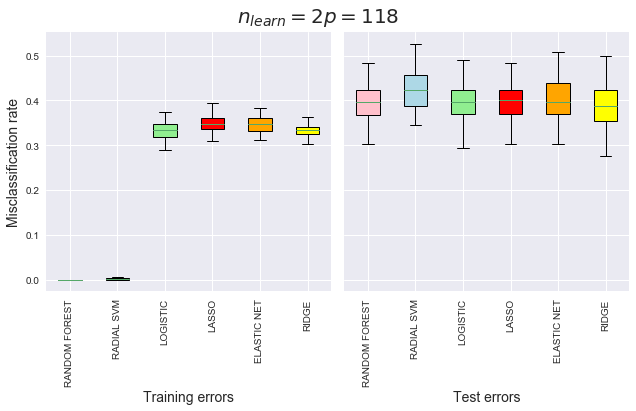

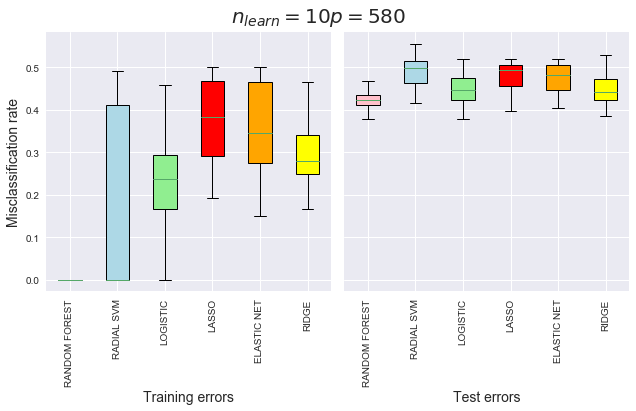

In [35]:
err_2p = restructured_results['2p']
err_10p = restructured_results['10p']

def make_plot(errs,label, p):
    #x
    X = list(errs['train'].keys())
    #y
    Y = {k:errs[k].values() for k in errs}
    #col
    COL = list(errs.keys())
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(9, 6))
    # rectangular box plot
    bplot1 = axes[0].boxplot(list(Y['train']),
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color
    axes[0].set_xlabel("Training errors", fontsize=14)
    axes[0].set_ylabel('Misclassification rate', fontsize=14)

    # notch shape box plot
    bplot2 = axes[1].boxplot(list(Y['test']),
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color
    axes[1].set_xlabel("Test errors", fontsize=14)

    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen', 'red', 'orange', 'yellow']
    for bplot in (bplot1, bplot2):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

    # adding horizontal grid lines
    for ax in axes:
        ax.yaxis.grid(True)
        ax.set_xticklabels(X, rotation = 90)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle("$n_{learn} = "+ label +" = "+str(p)+"$", fontsize=20)

    plt.savefig(label+'.png', dpi=1200)
    plt.show()
    
make_plot(err_2p, '2p', 118)
make_plot(err_10p, '10p', 580)


